# Replicate of 2D cancer shape contour examples

In this file, we show how to use the distance and MMD to perform hypothesis testing on 2D cell shape contours.

Before starting, the data should be downloaded from https://github.com/wxli0/dyn/tree/main%4092c7a58/dyn/datasets/breast_cancer.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import sys
sys.path.append('../Utils/')


from compute_kernel import compute_mmd, compute_kernel_matrix,compute_witness_function
from compute_kernel import permutation_test_mmd, compute_p_values
from utils_other import  compute_diffusion_map, compute_dimension_reduction_wasskernel
%load_ext autoreload
%autoreload 2

First we load the 2D cancer cell contours:

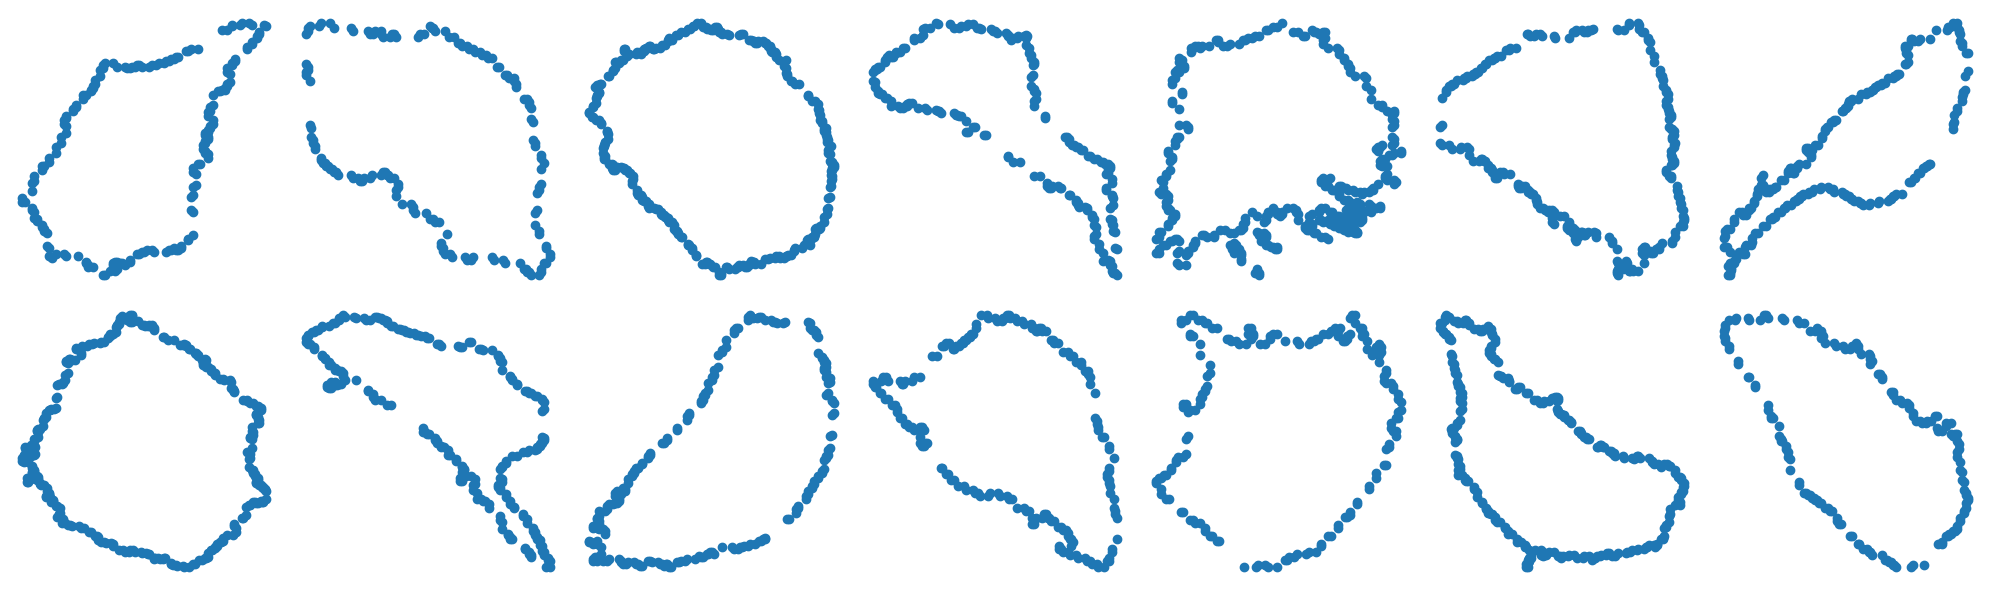

In [5]:
data = np.loadtxt('../../shape_dynamics/Data/CellShape/breastcancer/cells.txt')
def read_file_and_split_into_arrays(file_path):
    # Read the file content
    with open(file_path, 'r') as file:
        data = file.read()

    # Split the data into blocks where each block is separated by blank lines
    blocks = [block.strip().split('\n') for block in data.split('\n\n') if block.strip()]

    # Convert each block into arrays of tuples (each row as a tuple of integers)
    arrays = [[tuple(map(int, line.split())) for line in block] for block in blocks]

    return arrays

# Example usage
file_path = '../../shape_dynamics/Data/CellShape/breastcancer/cells.txt'  # Replace with your file path
arrays = read_file_and_split_into_arrays(file_path)

for i in range(len(arrays)):
    arrays[i] = np.array(arrays[i])
    
plt.rcParams["figure.figsize"] = (20,6)
N_cells = 14
# To see a sample output
for i, array in enumerate(arrays[:N_cells], 1):
    # print(f"Array {i}: {array}\n")
    plt.subplot(2,N_cells//2,i)
    array = np.array( array )
    plt.scatter(array[:,0], array[:,1])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
lines = []
with open('../../shape_dynamics/Data/CellShape/breastcancer/lines.txt') as f:
    lines = f.read().splitlines() 
all_lines = list( set(lines) )
all_lines = ['MCF10A','MCF7','MDA_MB_231']
idx_all = [0]*3
for i in range(3):
    idx_all[i] = []
for i in range(len(lines)):
   
    for j in range(3):
        if lines[i] == all_lines[j]:
            idx_all[j] += [i]


Next, we compute distances between each pair of shapes using various metrics.

In [ ]:
import time
start = time.time()
K_GW = compute_kernel_matrix(arrays,kernel_type='GW',normalize=True)
print(time.time()-start)

with open('K_GW_cell2', 'wb') as f:
    np.save(f, np.array(K_GW))   

In [72]:
import time
start = time.time()
K_W = compute_kernel_matrix(arrays,kernel_type='W_mine',normalize=True)
print(time.time()-start)

with open('K_Wasserstein_mine_cell2', 'wb') as f:
    np.save(f, np.array(K_W))    

677
100
1.3617987632751465


In [ ]:
import time
start = time.time()
K_Ws = compute_kernel_matrix(arrays,kernel_type='W_stratified',normalize=True)
print(time.time()-start)

with open('K_Wasserstein_stratified_cell2', 'wb') as f:
    np.save(f, np.array(K_Ws))    

To compare Type I and II errors, we perform permutation tests over a large number of experiments. The function below does this for various small sample sizes.

In [8]:
from compute_kernel import mmd2_permutation
def compute_type_12(K_type, n_exp=500, method='MMD'):
    np.random.seed(0)
    if K_type == 'GW':
        K = np.load('../Results/K_GW.npy')
        K = np.sqrt(K)
    elif K_type == 'W_stratified':
        K = np.load('../Results/K_Wasserstein_stratified_cell2')
        # K = K ** 2
    
        # K = K ** 2
    elif K_type == 'W_mine':
        K = np.load('../Results/K_Wasserstein_mine_cell2')
        # K = K ** 2
    elif K_type == 'W_improved':
        K = np.load('../Results/K_Wasserstein_improved_cell2')
    elif K_type == 'SRV':
        K = np.load('../Results/SRV_metric_cell2_processed')


    
    n_sample = [15,20,25,30,40,50,60]
    type_one_5 = [0]*len(n_sample)
    type_one_1 = [0]*len(n_sample)
    for n_id,n in enumerate(n_sample):
        p_all = np.zeros( (n_exp,1) )
        print(n_id)
        for j in range(len(p_all)):
            idx_part = np.random.permutation( len(idx_all[0]) )
            idx_part = [int(i) for i in idx_part]
            idx_part1 = [idx_all[0][idx_part[i]] for i in range(n) ] 
            idx_part2 = [idx_all[0][idx_part[i]] for i in range(n,2*n) ] 
            K_t = K[np.ix_(idx_part1+idx_part2, idx_part1+idx_part2)]
            # K_exp = np.exp( -K/np.median(K_t) )
            
            K_XX = K[np.ix_(idx_part1, idx_part1)]
            K_XX = np.exp(-K_XX/np.median(K_t) )
            K_XY = K[np.ix_(idx_part1, idx_part2)]
            K_XY = np.exp(-K_XY/np.median(K_t) )
            K_YY = K[np.ix_(idx_part2, idx_part2)]
            K_YY = np.exp(-K_YY/np.median(K_t) )
            # p_all[j], true_mmd, all_mmd = permutation_test_mmd(K_XX, K_YY, K_XY)
            #p_all[j] = compute_p_values(K_XX, K_YY, K_XY, method=method)
            if method == 'MMD':
                res = mmd2_permutation(np.exp(-K_t/np.median(K_t)), n)
            else:
                res = mmd2_permutation(-K_t, n)
            p_all[j] = res.p_value
        type_one_5[n_id] = np.sum( p_all < 0.05 )/len(p_all)
        type_one_1[n_id] = np.sum( p_all < 0.01 )/len(p_all)
        
    
    type_two_5 = [0]*len(n_sample)
    type_two_1 = [0]*len(n_sample)
    for n_id,n in enumerate(n_sample):
        p_all = np.zeros( (n_exp,1) )
        print(n_id)
        for j in range(len(p_all)):
            idx_part = np.random.permutation( 200 ) #len(idx_all[0]) )
            idx_part = [int(i) for i in idx_part]
            idx_part1 = [idx_all[0][idx_part[i]] for i in range(n) ] 
            idx_part = np.random.permutation( 200 )#len(idx_all[1]) )
            idx_part2 = [idx_all[1][idx_part[i]] for i in range(n) ] 
            K_t = K[np.ix_(idx_part1+idx_part2, idx_part1+idx_part2)]
            # K_exp = np.exp( -K/np.median(K_t) )
            
            
            K_XX = K[np.ix_(idx_part1, idx_part1)]
            K_XX = np.exp(-K_XX/np.median(K_t) )
            K_XY = K[np.ix_(idx_part1, idx_part2)]
            K_XY = np.exp(-K_XY/np.median(K_t) )
            K_YY = K[np.ix_(idx_part2, idx_part2)]
            K_YY = np.exp(-K_YY/np.median(K_t) )
            # p_all[j], true_mmd, all_mmd = permutation_test_mmd(K_XX, K_YY, K_XY)
            # p_all[j] = compute_p_values(K_XX, K_YY, K_XY, method=method)
            if method == 'MMD':
                res = mmd2_permutation(np.exp(-K_t/np.median(K_t)), n)
            else:
                res = mmd2_permutation(-K_t, n)
            p_all[j] = res.p_value
        type_two_5[n_id] = np.sum( p_all > 0.05 )/len(p_all)
        type_two_1[n_id] = np.sum( p_all > 0.01 )/len(p_all)
    
    
    plt.plot(n_sample, type_one_5,'ro-',label=r'Type I,$\alpha=5\%$')
    plt.plot(n_sample, type_one_1,'ro:',label=r'Type I,$\alpha=1\%$')
    
    plt.plot(n_sample, type_two_5,'bs-',label=r'Type II,$\alpha=5\%$')
    plt.plot(n_sample, type_two_1,'bs:',label=r'Type II,$\alpha=1\%$')
    
    # plt.ylim([0,0.3])
    plt.xlabel('Number of shapes')
    plt.legend()
    plt.show()
    return type_one_5, type_one_1, type_two_5, type_two_1

GW
0


/var/folders/k7/s0t_zwg11h56xb5xp339s5pm0000gp/T/ipykernel_9812/221105294.py:48: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  p_all[j] = res.p_value


1
2
3
4
5
6
0


/var/folders/k7/s0t_zwg11h56xb5xp339s5pm0000gp/T/ipykernel_9812/221105294.py:80: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  p_all[j] = res.p_value


1
2
3
4
5
6


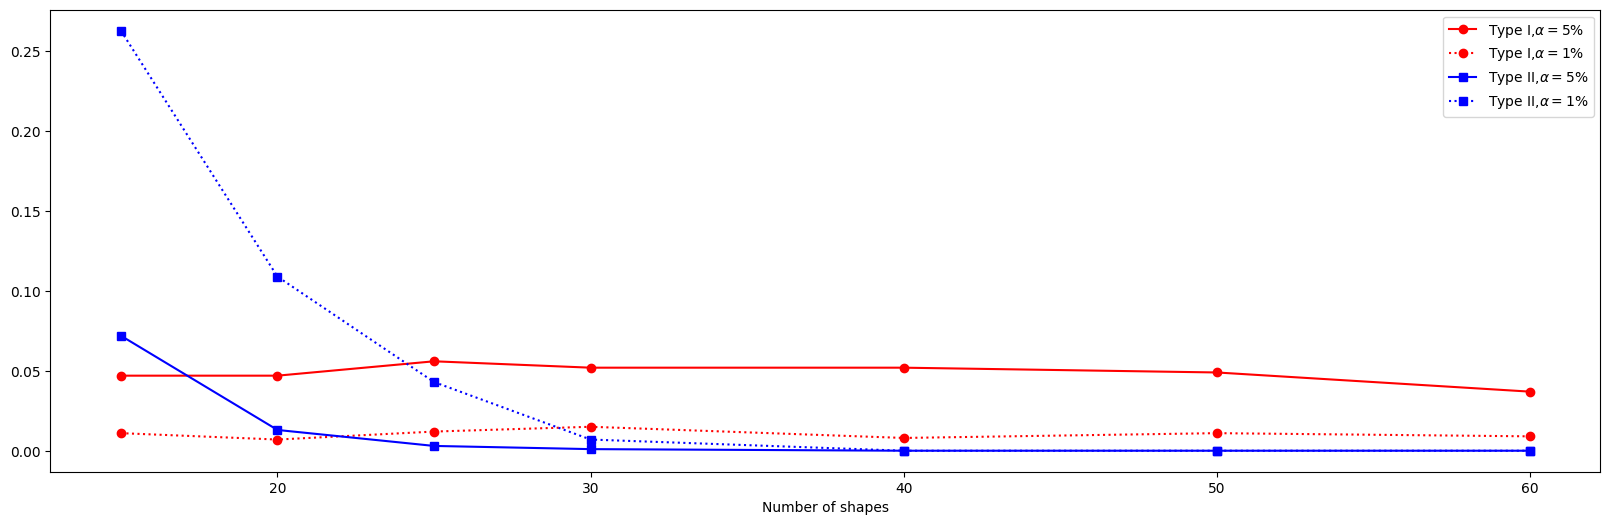

W_mine
0
1
2
3
4
5
6
0
1
2
3
4
5
6


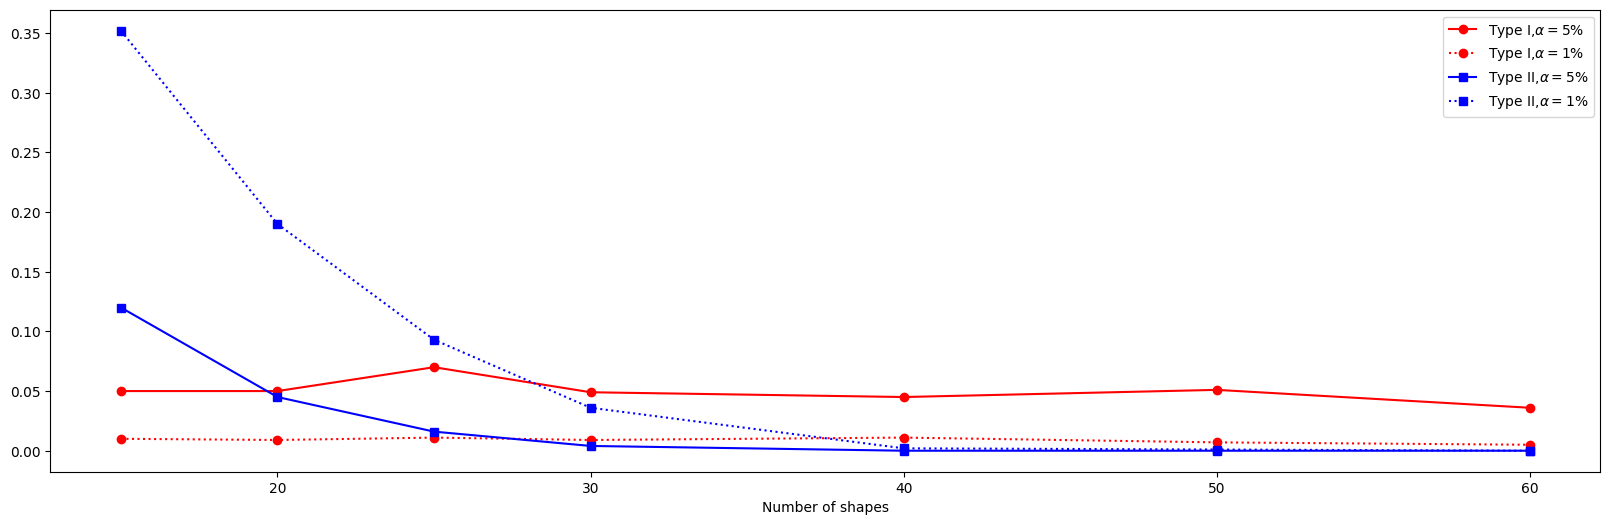

W_stratified
0
1
2
3
4
5
6
0
1
2
3
4
5
6


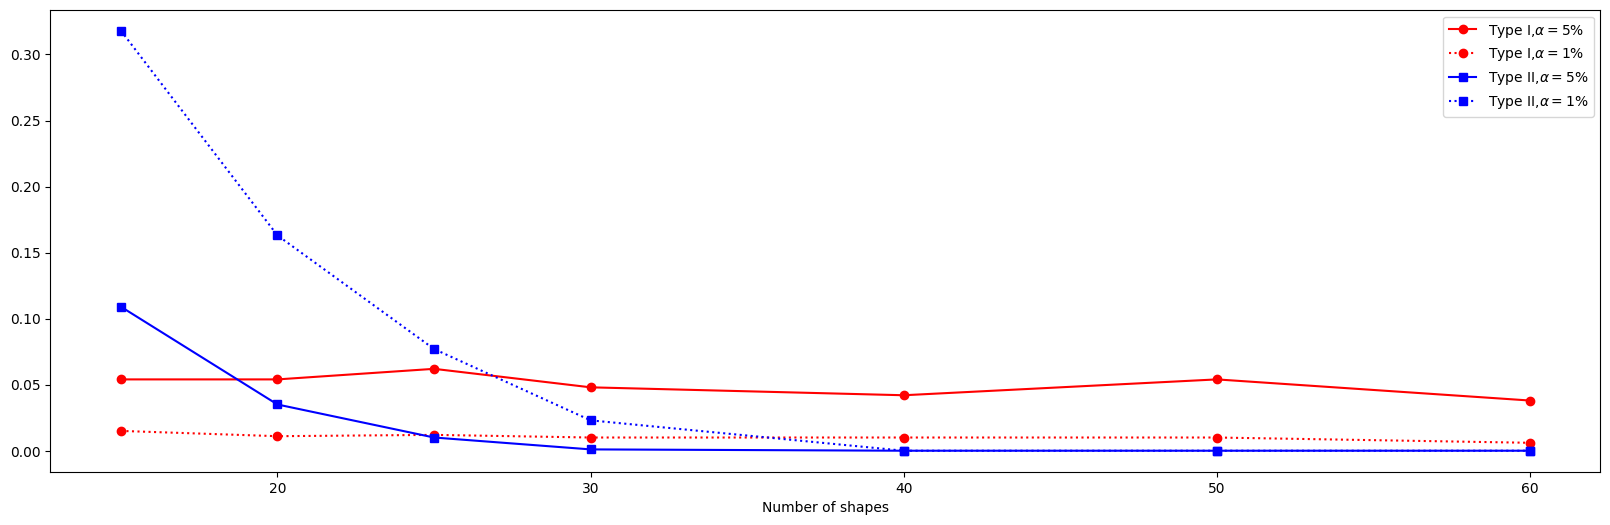

W_improved
0
1
2
3
4
5
6
0
1
2
3
4
5
6


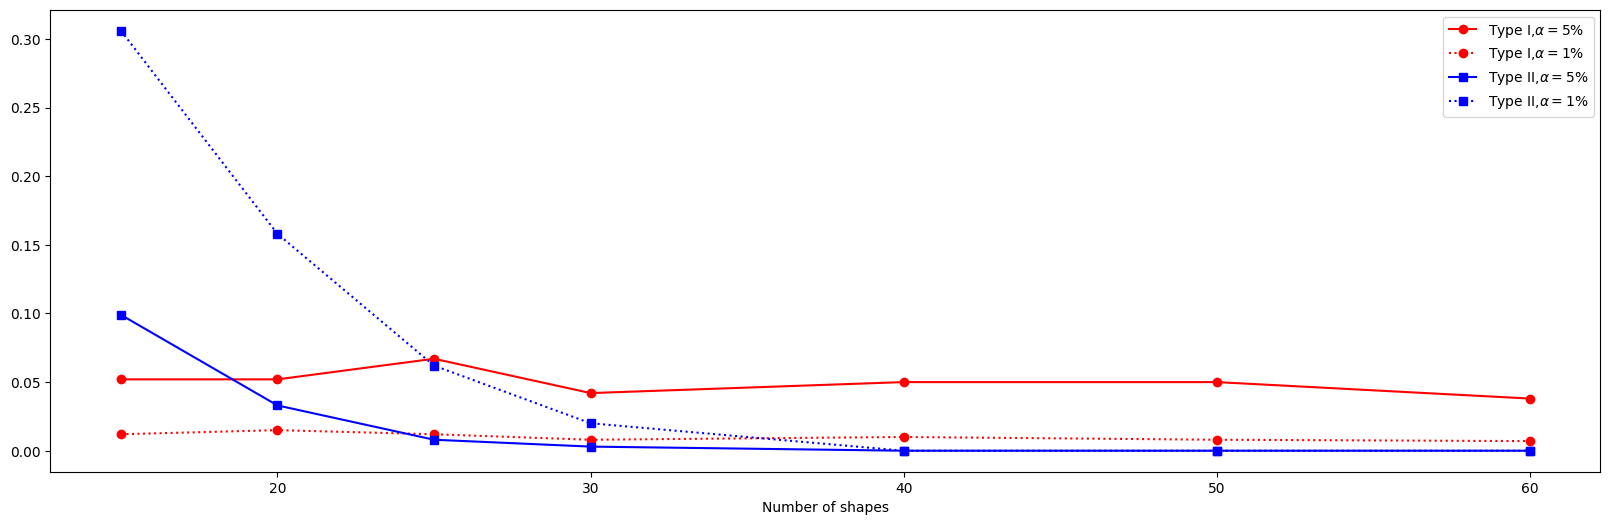

SRV
0
1
2
3
4
5
6
0
1
2
3
4
5
6


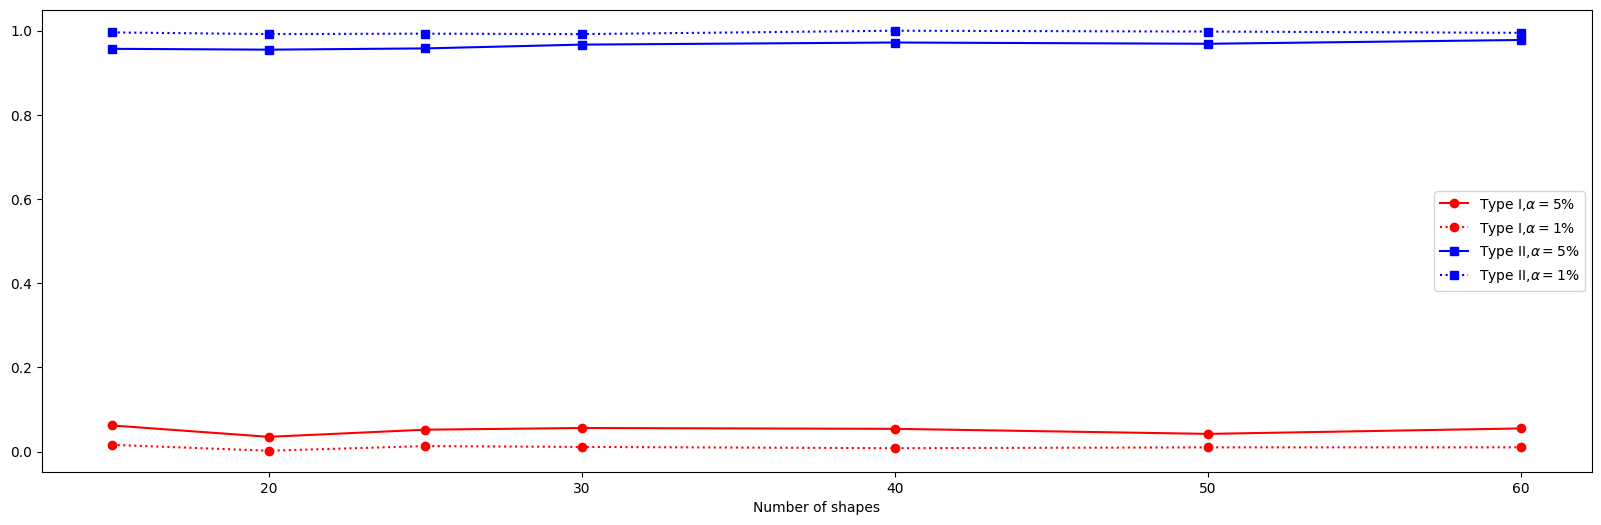

In [11]:
K_types = ['GW','W_mine','W_stratified','W_improved','SRV']
type_one_5 = [0]*len(K_types)
type_one_1 = [0]*len(K_types)
type_two_5 = [0]*len(K_types)
type_two_1 = [0]*len(K_types)

for i,K_type in enumerate(K_types):
    print(K_type)
    type_one_5[i], type_one_1[i], type_two_5[i], type_two_1[i] = compute_type_12(K_type = K_type, n_exp=1000, method='energy')

The cell below shows how to use witness function to rank cells according to their extremeness:

[ 26  35  47  70  81  84 100 102 111 117 127 130 137 138 159 167 173 183
 186 190 211 213 218]


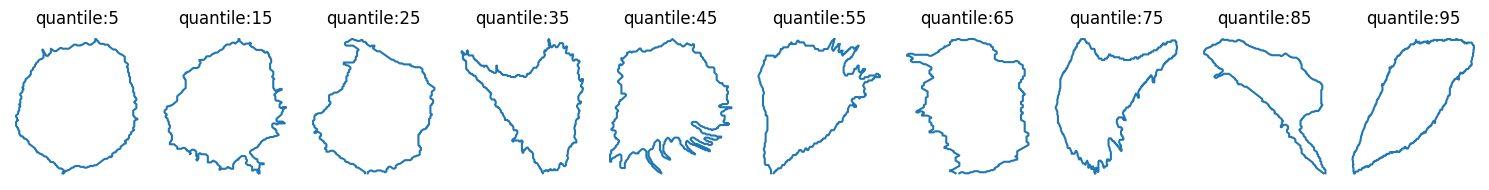

In [9]:
plt.figure(figsize=(15, 2))
K = np.load('../Results/K_Wasserstein_stratified_cell2')
# K = np.load('K_Wasserstein_mine_cell2')
K = np.exp(-K/np.median(K))
K_XX = K[np.ix_(idx_all[0], idx_all[0])]
K_XY = K[np.ix_(idx_all[0], idx_all[1])]
K_YY = K[np.ix_(idx_all[1], idx_all[1])]

witness_values = [0]*len(idx_all[0])
for i in range(len(idx_all[0])):
    
    witness_values[i] = compute_witness_function(i, K_XX, K_XY)

idx_max = np.where( np.array(witness_values) > np.quantile(witness_values,0.9) )[0]
print(idx_max)
idx_max = [idx_all[0][i] for i in idx_max]
for i in range(10):
    plt.subplot(1,10,i+1)
    idx_max = np.where( (np.array(witness_values) > np.quantile(witness_values,0.1*i+0.04)) & (np.array(witness_values) < np.quantile(witness_values,0.1*i+0.06)) )[0][0]
    idx_max = idx_all[0][idx_max]
    plt.plot(arrays[idx_max][:,0], arrays[idx_max][:,1])
    plt.axis('off')
    plt.title('quantile:'+str(10*i+5))
plt.tight_layout()
# plt.savefig('Figures/cells_ranked.png')
plt.show()

Finally, the cell below shows how to compute a single p-value and visualize it against the simulated null distribution:

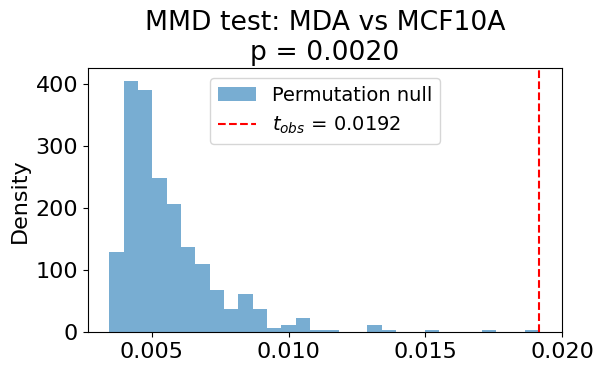

In [10]:
plt.rcParams['font.size']=16
from compute_kernel import mmd2_permutation
K = np.load('../Results/K_Wasserstein_stratified_cell2')

K_t = K[np.ix_(idx_all[0] + idx_all[2], idx_all[0] + idx_all[2])] # two cancer lines
res1 = mmd2_permutation(np.exp(-K_t/np.median(K_t)), len(idx_all[0]))#,n_perm=1000)
res1.estimate

plt.figure(figsize=(6,4))
plt.hist(res1.permuted_estimates, bins=30, density=True, alpha=0.6, label="Permutation null")
plt.axvline(res1.estimate, color='red', linestyle='--', label=f"$t_{{obs}}$ = {res1.estimate:.4f}")
# plt.xlabel(r"$t = \mathrm{MMD}^2(MCF10A,MDA)$")
plt.ylabel("Density")
plt.title(f"MMD test: MDA vs MCF10A\np = {res1.p_value:.4f}")
plt.legend(fontsize=14)
plt.tight_layout()
plt.xticks([0.005,0.01,0.015,0.02])
# plt.savefig('../Figures/p-value-absolute.pdf',bbox_inches='tight')
plt.show()
